In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster

import warnings
warnings.filterwarnings("ignore")

# Reading and wrangling data
 - [Task link](https://www.coursera.org/learn/unsupervised-learning/programming/XXda2/razmieshchieniie-bannierov)

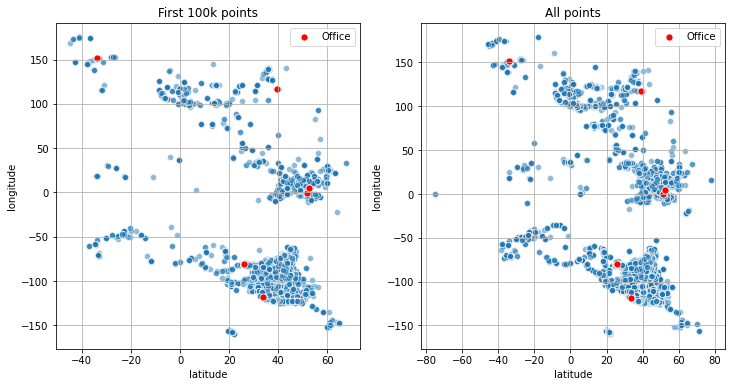

In [2]:
# Reading data
data = pd.read_csv('https://raw.githubusercontent.com/evgeni-nabokov/ml-and-da-by-mipt-and-yandex/master/C3W1/checkins.csv',
                   parse_dates=['created_at'])
offices = pd.DataFrame([(33.751277, -118.188740, 'Los Angeles'),
                        (25.867736, -80.324116, 'Miami'),
                        (51.503016, -0.075479, 'London'),
                        (52.378894, 4.885084, 'Amsterdam'),
                        (39.366487, 117.036146, 'Beijing'),
                        (-33.868457, 151.205134, 'Sydney')], columns=['latitude','longitude','city'])

# Plots (sample of first 100k and population)
f, ax = plt.subplots(1,2,figsize=(12, 6))
## 1st plot (sample)
sns.scatterplot(x='latitude', y='longitude', data=data[:100000], alpha=0.5, ax=ax[0])
sns.scatterplot(x='latitude', y='longitude', s=50, data=offices, color='red', label='Office', ax=ax[0])
ax[0].legend()
ax[0].set_title('First 100k points')
ax[0].grid()
## 2nd plot (population)
sns.scatterplot(x='latitude', y='longitude', data=data, alpha=0.5, ax=ax[1])
sns.scatterplot(x='latitude', y='longitude', s=50, data=offices, color='red', label='Office', ax=ax[1])
ax[1].legend()
ax[1].set_title('All points')
ax[1].grid()
plt.show()

# Wrangling data
data = data.iloc[:100000]

# Analysis

In [3]:
%%time
model = cluster.MeanShift(bandwidth=0.1)
data['clusterLabel'] = model.fit_predict(data[['latitude','longitude']])

# Size of clusters
clusters = data.groupby(by='clusterLabel').agg({'clusterLabel': len})
clusters.columns = ['count']
clusters.reset_index(inplace=True)

# Center of clusters
cluster_centers = pd.DataFrame(model.cluster_centers_, columns=['latitude_clusterCenter','longitude_clusterCenter'])
cluster_centers.reset_index(inplace=True); cluster_centers.rename(columns={'index':'clusterLabel'}, inplace=True)
cluster_centers = clusters.merge(cluster_centers, how='left', on=['clusterLabel'])

# Min distance between center of cluster and offices
## Function to calculate the min distance
def min_distance(df):
    min_distance = float('inf')
    lat_center, lon_center = df['latitude_clusterCenter'], df['longitude_clusterCenter']
    for i in range(offices.shape[0]):
        df_i = offices.iloc[i]
        lat_office, lon_office = df_i['latitude'], df_i['longitude']
        ## Distance based on latitude and longitude
        ### Formula (pt.1)
        #lat_center = np.radians(lat_center)
        #lon_center = np.radians(lon_center)
        #lat_office = np.radians(lat_office)
        #lon_office = np.radians(lon_office)
        ### Formula (pt.2)
        #dlat = lat_center - lat_office
        #dlon = lon_center - lon_office
        ### Formula (pt.3)
        #a = np.sin(dlat/2)**2 + np.cos(lat_center)*np.cos(lat_office) + np.sin(dlon/2)**2
        #c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        ### Formula (pt.4)
        #R = 6373.0 # Radius of the Earth (km)
        #current_distance = R*c
        ## Comparison the distances
        current_distance = np.sqrt((lat_center - lat_office)**2 + (lon_center - lon_office)**2)
        if current_distance<min_distance:
            min_distance = current_distance
    return min_distance
## Calculating the min distance
cluster_centers['min_distance'] = cluster_centers.apply(min_distance, axis=1)

Wall time: 3min 11s


In [4]:
cluster_centers.head()

,clusterLabel,count,latitude_clusterCenter,longitude_clusterCenter,min_distance
0,0,12506,40.717716,-73.991835,16.143720
1,1,4692,33.449438,-112.002140,6.193959
2,2,3994,33.446380,-111.901888,6.294241
3,3,3363,41.878244,-87.629843,17.598580
4,4,3526,37.688682,-122.409330,5.772048


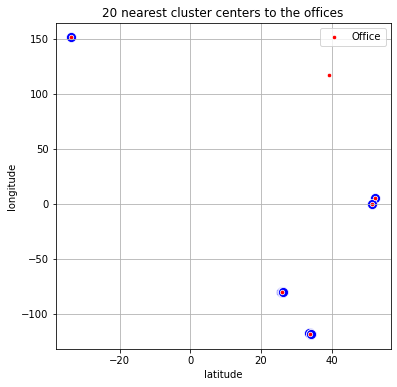

,clusterLabel,count,latitude_clusterCenter,longitude_clusterCenter,min_distance
420,420,28,-33.860630,151.204776,0.007835
370,370,31,52.372964,4.892317,0.009353
419,419,28,25.845672,-80.318891,0.022674
58,58,254,51.502991,-0.125537,0.050058
51,51,281,33.809878,-118.148924,0.070848
29,29,564,25.785812,-80.217938,0.134109
167,167,80,25.705350,-80.283429,0.167406
92,92,138,26.010098,-80.199991,0.188876
87,87,100,33.888325,-118.048928,0.195779
42,42,384,33.872986,-118.362091,0.211811


In [5]:
results = cluster_centers[cluster_centers['count']>15].sort_values(by=['min_distance'], ascending=True).head(20)

# Plot (results)
plt.figure(figsize=(6,6))
sns.scatterplot(x='latitude_clusterCenter', y='longitude_clusterCenter', data=results, color='blue', s=100) # Cluster centers
sns.scatterplot(x='latitude', y='longitude', s=20, data=offices, color='red', label='Office') # Offices
plt.legend()
plt.title('20 nearest cluster centers to the offices')
plt.grid()
plt.show()

results

In [6]:
results[['latitude_clusterCenter','longitude_clusterCenter']].head(1).to_csv('solution.txt', sep=' ', header=False, index=False)